## Homework

> Note: sometimes your answer doesn't match one of the options exactly. That's fine. 
Select the option that's closest to your solution.


## Dataset

In this homework, we will use Credit Card Data from book "Econometric Analysis".

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
```
The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column `card`). 

In [1]:
!curl https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv > data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73250  100 73250    0     0  99161      0 --:--:-- --:--:-- --:--:--  102k


## Preparation

* Create the target variable by mapping `yes` to 1 and `no` to 0. 
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`.

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.model_selection import KFold

In [3]:
df=pd.read_csv("data.csv")
df["target"]=np.where(df["card"]=="yes",1,0)
del df["card"]

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.2, random_state=1)

y_train = df_train.target.values
y_val = df_val.target.values
y_test = df_test.target.values
del df_train['target']
del df_val['target']
del df_test['target']
categorical = ['owner', 'selfemp']
numerical = ['reports', 'age', 'income', 'share', 'expenditure','dependents', 'months', 'majorcards', 'active']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `card` variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- `share`


In [4]:
results={}
for feature in numerical:
    
    model = LogisticRegression(solver='liblinear', random_state=1)
    model.fit(df_train[feature].values.reshape(-1,1), y_train)
    results[feature+"_train"]=roc_auc_score(y_train,model.predict_proba(df_train[feature].values.reshape(-1,1))[:,1])
    results[feature+"_val"]=roc_auc_score(y_val,model.predict_proba(df_val[feature].values.reshape(-1,1))[:,1])
    results[feature+"_test"]=roc_auc_score(y_test,model.predict_proba(df_test[feature].values.reshape(-1,1))[:,1])
    
    

In [5]:
results

{'reports_train': 0.712027608884982,
 'reports_val': 0.7339424141749723,
 'reports_test': 0.7237526782981328,
 'age_train': 0.5143253648491359,
 'age_val': 0.46068660022148394,
 'age_test': 0.4881389654116926,
 'income_train': 0.5897655035447138,
 'income_val': 0.5596622369878185,
 'income_test': 0.6054866850321395,
 'share_train': 0.9899763143115278,
 'share_val': 0.9820044296788483,
 'share_test': 0.9970538720538721,
 'expenditure_train': 0.9916286149162861,
 'expenditure_val': 0.9791666666666667,
 'expenditure_test': 0.9924242424242424,
 'dependents_train': 0.529468740588805,
 'dependents_val': 0.46629291251384275,
 'dependents_test': 0.5592669115396388,
 'months_train': 0.5231769752317698,
 'months_val': 0.5110741971207088,
 'months_test': 0.5044000612182431,
 'majorcards_train': 0.5362163130092219,
 'majorcards_val': 0.56187707641196,
 'majorcards_test': 0.5833333333333333,
 'active_train': 0.6101669393369635,
 'active_val': 0.5087901439645626,
 'active_test': 0.5542546678910315}

Therefore "share" gives the maximum value

## Training the model

From now on, use these columns only:

```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```



In [6]:
columns_to_use=["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
train_dict = df_train[columns_to_use].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)
model = LogisticRegression(solver='liblinear',C=1.0,max_iter=1000)
model.fit(X_train,y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- 0.995


In [7]:
y_pred=model.predict_proba(X_train)[:,1]
print(round(roc_auc_score(y_train,y_pred),3))

0.998


In [8]:
y_pred_val=model.predict_proba(dv.transform(df_val[columns_to_use].to_dict(orient="records")))[:,1]
print(round(roc_auc_score(y_val,y_pred_val),3))

0.994


In [9]:
pd.Series(y_val).value_counts(normalize=True)

1    0.796209
0    0.203791
dtype: float64

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

* 0.1
* 0.3
* 0.6
* 0.8

In [10]:
def precision_recall_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        fp = ((y_pred >= t) & (y_val == 0)).sum()
        fn = ((y_pred < t) & (y_val == 1)).sum()
        tn = ((y_pred < t) & (y_val == 0)).sum()

        scores.append((t, tp, fp, fn, tn))

    df_scores = pd.DataFrame(scores)
    df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

    return df_scores


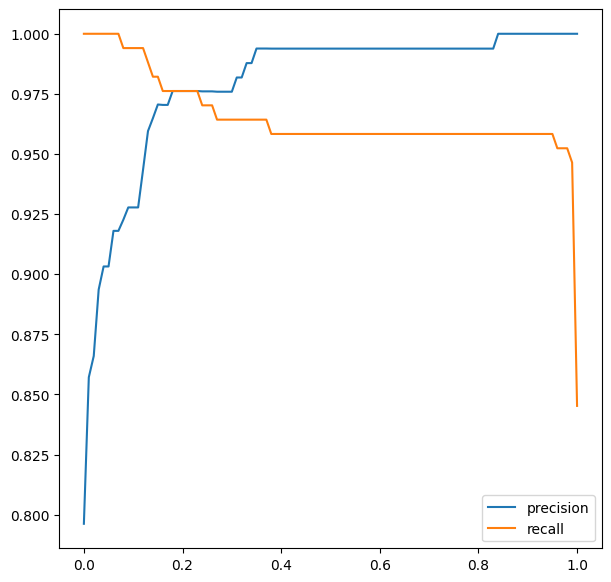

In [11]:
df_scores=precision_recall_dataframe(y_val,y_pred_val)
plt.figure(figsize=(7,7))
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

In [12]:
df_scores[10:30:]

,threshold,tp,fp,fn,tn,precision,recall
10,0.10,167,13,1,30,0.927778,0.994048
11,0.11,167,13,1,30,0.927778,0.994048
12,0.12,167,10,1,33,0.943503,0.994048
13,0.13,166,7,2,36,0.959538,0.988095
14,0.14,165,6,3,37,0.964912,0.982143
15,0.15,165,5,3,38,0.970588,0.982143
16,0.16,164,5,4,38,0.970414,0.976190
17,0.17,164,5,4,38,0.970414,0.976190
18,0.18,164,4,4,39,0.976190,0.976190
19,0.19,164,4,4,39,0.976190,0.976190


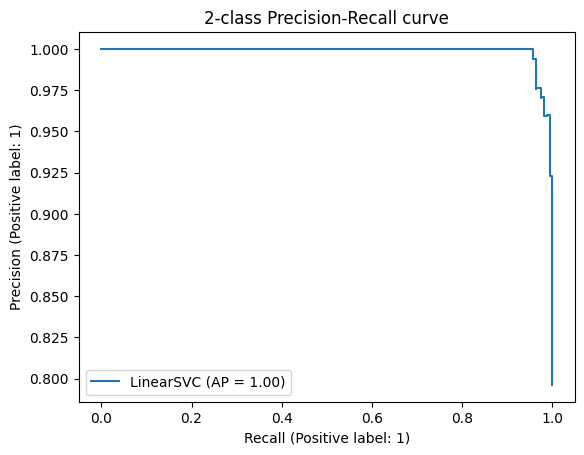

In [13]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    model,dv.transform(df_val[columns_to_use].to_dict(orient="records")), y_val, name="LinearSVC"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7

In [14]:
df_scores["F1"]=2*df_scores["precision"]*df_scores["recall"]/(df_scores["precision"]+df_scores["recall"])

In [15]:
df_scores[::10]

,threshold,tp,fp,fn,tn,precision,recall,F1
0,0.0,168,43,0,0,0.796209,1.000000,0.886544
10,0.1,167,13,1,30,0.927778,0.994048,0.959770
20,0.2,164,4,4,39,0.976190,0.976190,0.976190
30,0.3,162,4,6,39,0.975904,0.964286,0.970060
40,0.4,161,1,7,42,0.993827,0.958333,0.975758
50,0.5,161,1,7,42,0.993827,0.958333,0.975758
60,0.6,161,1,7,42,0.993827,0.958333,0.975758
70,0.7,161,1,7,42,0.993827,0.958333,0.975758
80,0.8,161,1,7,42,0.993827,0.958333,0.975758
90,0.9,161,0,7,43,1.000000,0.958333,0.978723


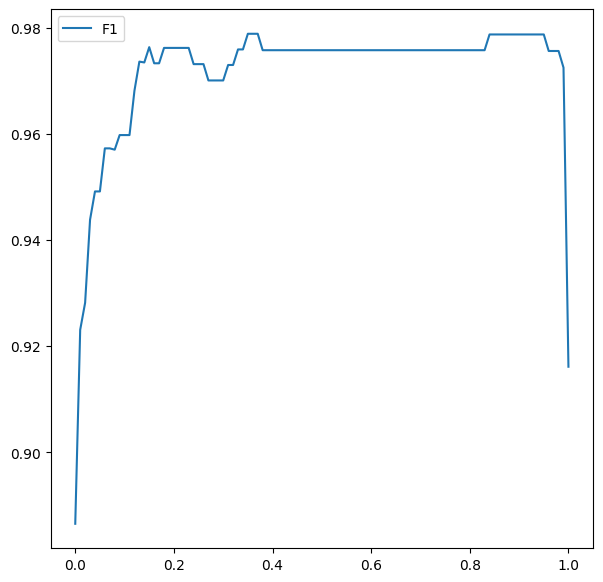

In [16]:
plt.figure(figsize=(7,7))
plt.plot(df_scores.threshold, df_scores['F1'], label='F1')
plt.legend()

In [17]:
df_scores.iloc[df_scores["F1"].sort_values(ascending=False).index]

,threshold,tp,fp,fn,tn,precision,recall,F1
37,0.37,162,1,6,42,0.993865,0.964286,0.978852
35,0.35,162,1,6,42,0.993865,0.964286,0.978852
36,0.36,162,1,6,42,0.993865,0.964286,0.978852
89,0.89,161,0,7,43,1.000000,0.958333,0.978723
84,0.84,161,0,7,43,1.000000,0.958333,0.978723
...,...,...,...,...,...,...,...,...
3,0.03,168,20,0,23,0.893617,1.000000,0.943820
2,0.02,168,26,0,17,0.865979,1.000000,0.928177
1,0.01,168,28,0,15,0.857143,1.000000,0.923077
100,1.00,142,0,26,43,1.000000,0.845238,0.916129


## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24


In [18]:
def train(df, y):
    cat = df[columns_to_use].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear',C=1.0,max_iter=1000)
    model.fit(X, y)

    return dv, model


def predict(df, dv, model):
    cat = df[columns_to_use].to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


kfold = KFold(n_splits=5, shuffle=True, random_state=1)

aucs = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    y_train = df_train.target.values

    df_val = df_train_full.iloc[val_idx]
    y_val = df_val.target.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)
print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

auc = 0.996 ± 0.003


## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [19]:
def train(df, y, C=1.0):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C,max_iter=1000)
    model.fit(X, y)

    return dv, model

In [20]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for C in [0.01, 0.1,1, 10]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.target.values
        y_val = df_val.target.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=0.01, auc = 0.992 ± 0.006
C=0.1, auc = 0.995 ± 0.004
C=1, auc = 0.996 ± 0.003
C=10, auc = 0.996 ± 0.003


## Submit the results

* Submit your results here: https://forms.gle/8TfKNRd5Jq7sGK5M9
* You can submit your solution multiple times. In this case, only the last submission will be used 
* If your answer doesn't match options exactly, select the closest one


## Deadline

The deadline for submitting is October 3 (Monday), 23:00 CEST.

After that, the form will be closed.